This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter

In [1]:
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys
# sys.path.insert(0, '../libraries/')
# sys.path.insert(0, '../../BNP_modeling/')

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import json 

/home/rgiordan/Documents/git_repos/BNP_sensitivity/GMM_clustering/venv/lib/python3.5/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

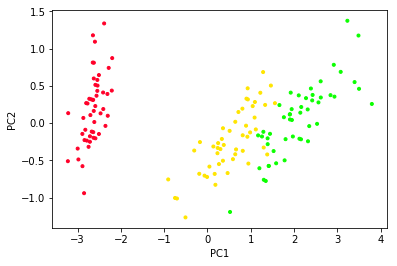

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = 3.5
print(prior_params_dict)

{'prior_gamma_df': array([8.]), 'prior_centroid_info': array([0.1]), 'prior_centroid_mean': array([0.]), 'alpha': 3.5, 'prior_gamma_inv_scale': array([[0.62, 0.  , 0.  , 0.  ],
       [0.  , 0.62, 0.  , 0.  ],
       [0.  , 0.  , 0.62, 0.  ],
       [0.  , 0.  , 0.  , 0.62]])}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 30

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
stick_propn_mean = vb_params_dict['stick_propn_mean']
stick_propn_info = vb_params_dict['stick_propn_info']

In [9]:
cluster_lib.get_e_number_clusters_from_logit_sticks(stick_propn_mean, stick_propn_info, n_obs, n_samples=100)

5.545023494918516

In [10]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1460.205125758913

# Optimize the KL objective

### Initialize with k-means

In [11]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                  seed = 453453)

print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
450.9718947107098


### Set up KL objective as a function of unconstrained VB parameters

In [12]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_loss = lambda x : get_vb_params_loss(features, x, prior_params_dict, gh_loc, gh_weights)


### Run Newton 

In [13]:
vb_opt = optimization_lib.optimize_full(get_loss, init_vb_free_params,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = 450.97189471
Iter 1: f = 288.42252948
Iter 2: f = 132.82724910
Iter 3: f = 849.69522338
Iter 4: f = 102.95800124
Iter 5: f = 69.15077895
Iter 6: f = 35.10598280
Iter 7: f = 149.86270237
Iter 8: f = 27.90810015
Iter 9: f = 15.66532676
Iter 10: f = -4.96037757
Iter 11: f = -35.63242473
Iter 12: f = -69.57876702
Iter 13: f = -106.48627732
Iter 14: f = -109.56137218
Iter 15: f = -129.49640794
Iter 16: f = -148.49222218
Iter 17: f = -180.42498864
Iter 18: f = -183.90475287
Iter 19: f = -197.82029664
Iter 20: f = -223.21611941
Iter 21: f = -210.67850230
Iter 22: f = -233.90999359
Iter 23: f = -248.01428698
Iter 24: f = -266.50049101
Iter 25: f = -275.43483870
Iter 26: f = -288.85589805
Iter 27: f = -294.21119573
Iter 28: f = -301.02567169
Iter 29: f = -309.37688825
Iter 30: f = -321.41152123
Iter 31: f = -317.57546051
Iter 32: f = -326.55252540
Iter 33: f = -332.95619469
Iter 34: f = -339.92264168
Iter 35: f = -342.52883975
Iter 36: f = -346.68395276
Iter 37: f 

In [14]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

### Check results

In [15]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

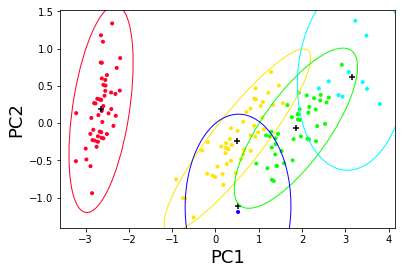

In [16]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Parametric sensitivity

### Get the hyper parameter sensitivity object

In [17]:
get_prior_vb_loss = paragami.FlattenFunctionInput(original_fun=gmm_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [18]:
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = lambda x, y: get_prior_vb_loss(features, x, y, gh_loc, gh_weights),
        opt_par_value = vb_opt, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
        validate_optimum=False,
        hessian_at_opt=None,
        cross_hess_at_opt=None,
        factorize_hessian=True,
        hyper_par_objective_fun=None,
        grad_tol=1e-8)


### Set new prior

In [19]:
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['alpha'] = new_alpha


In [20]:
print('initial alpha, ', prior_params_dict['alpha'])
print('perturbed alpha, ', prior_params_pert_dict['alpha'])

initial alpha,  3.5
perturbed alpha,  [5.]


### get linear response prediction

In [21]:
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True))

In [22]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))

l_inf diff:  0.41804611256537694


### re-optimize

In [23]:
# set up new objective, with the prior changed
get_pert_loss = lambda x : get_vb_params_loss(features, x, prior_params_pert_dict, gh_loc, gh_weights)

In [24]:
# Run newton
vb_opt_pert = optimization_lib.optimize_full(get_pert_loss, deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = -355.88279216
Iter 1: f = -355.47206397
Iter 2: f = -356.43067465
Iter 3: f = -347.97505340
Iter 4: f = -356.46261456
Iter 5: f = -356.51781014
Iter 6: f = -356.61847876
Iter 7: f = -356.69192515
Iter 8: f = -356.76307071
Iter 9: f = -356.85883828
Iter 10: f = -356.92862113
Iter 11: f = -356.98569526
Iter 12: f = -357.05655620
Iter 13: f = -357.16414334
Iter 14: f = -357.27229162
Iter 15: f = -357.29187420
Iter 16: f = -357.32755786
Iter 17: f = -357.36171780
Iter 18: f = -357.41744387
Iter 19: f = -357.45662339
Iter 20: f = -357.52003670
Iter 21: f = -357.61599039
Iter 22: f = -357.69223040
Iter 23: f = -357.50371864
Iter 24: f = -357.70972170
Iter 25: f = -357.72385874
Iter 26: f = -357.74420642
Iter 27: f = -357.77833690
Iter 28: f = -357.81515995
Iter 29: f = -357.76460484
Iter 30: f = -357.82629728
Iter 31: f = -357.83715272
Iter 32: f = -357.85231113
Iter 33: f = -357.85421617
Iter 34: f = -357.85774532
Iter 35: f = -357.85985807
Iter 36: f = -357.86

### Compare linear response with refitting

In [25]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')

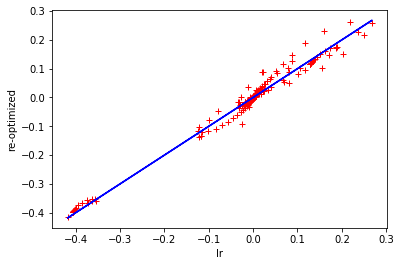

In [26]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

# Fit for a range of alpha 

In [27]:
alpha_list = np.arange(1, 15)

In [28]:
def refit_with_alpha(alpha, vb_opt):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # set up new objective, with the prior changed
    get_pert_loss = lambda x : get_vb_params_loss(features, x, prior_params_pert_dict, gh_loc, gh_weights)
    
    # optimize
    vb_opt_pert = optimization_lib.optimize_full(get_pert_loss,deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    return vb_opt_pert

### Re-optimize for range of alphas

In [29]:
print('alphas: ', alpha_list)

alphas:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [ ]:
vb_pert_list = []
for alpha in alpha_list: 
    print('re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, vb_opt))

re-optimzing with alpha =  1
running bfgs ... 
Iter 0: f = -398.63610283
Iter 1: f = -400.35032788
Iter 2: f = -379.17314823
Iter 3: f = -400.47356230
Iter 4: f = -400.68723386
Iter 5: f = -401.09016228
Iter 6: f = -401.57313651
Iter 7: f = -402.05249075
Iter 8: f = -402.64346278
Iter 9: f = -403.07387766
Iter 10: f = -403.57638110
Iter 11: f = -403.70546110
Iter 12: f = -403.94705883
Iter 13: f = -404.38767801
Iter 14: f = -404.83662672
Iter 15: f = -405.62022334
Iter 16: f = -406.28136972
Iter 17: f = -407.32200009
Iter 18: f = -406.32777353
Iter 19: f = -407.69109255
Iter 20: f = -408.09228672
Iter 21: f = -408.78853658
Iter 22: f = -409.71461047
Iter 23: f = -410.58947334
Iter 24: f = -410.49676717
Iter 25: f = -411.00191595
Iter 26: f = -410.90702928
Iter 27: f = -411.18591650
Iter 28: f = -411.46535780
Iter 29: f = -411.58233791
Iter 30: f = -411.75520787
Iter 31: f = -411.76162794
Iter 32: f = -411.84451723
Iter 33: f = -411.97803652
Iter 34: f = -412.08365768
Iter 35: f = -412.

Iter 102: f = -391.45687274
Iter 103: f = -391.45687277
Iter 104: f = -391.45687278
Iter 105: f = -391.45687277
Iter 106: f = -391.45687278
Iter 107: f = -391.45687278
Iter 108: f = -391.45687279
Iter 109: f = -391.45687279
Iter 110: f = -391.45687279
Iter 111: f = -391.45687279
Iter 112: f = -391.45687279
Iter 113: f = -391.45687279
Iter 114: f = -391.45687279
Iter 115: f = -391.45687279
Iter 116: f = -391.45687279
Iter 117: f = -391.45687279
Iter 118: f = -391.45687279
Iter 119: f = -391.45687279
Iter 120: f = -391.45687279
Iter 121: f = -391.45687279
Iter 122: f = -391.45687279
Iter 123: f = -391.45687279
Iter 124: f = -391.45687279
Iter 125: f = -391.45687279
Iter 126: f = -391.45687279
Iter 127: f = -391.45687279
Iter 128: f = -391.45687279
Iter 129: f = -391.45687279
Iter 130: f = -391.45687279
Iter 131: f = -391.45687279
Iter 132: f = -391.45687279
Iter 133: f = -391.45687279
Iter 134: f = -391.45687279
Iter 135: f = -391.45687279
Iter 136: f = -391.45687279
Iter 137: f = -391.4

preconditioning time: 10.01
running newton steps
Iter 0: f = -377.56871872
Iter 1: f = -377.56871872
Optimization terminated successfully.
         Current function value: -377.568719
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 2
Iter 0: x_diff = 2.3340877253684314e-05, f_diff = 1.5347723092418164e-12, grad_l1 = 8.537605994965896e-11
done. 
re-optimzing with alpha =  4
running bfgs ... 
Iter 0: f = -366.57111983
Iter 1: f = -365.30774846
Iter 2: f = -366.63416246
Iter 3: f = -365.68932787
Iter 4: f = -366.63794397
Iter 5: f = -366.64448834
Iter 6: f = -366.65650409
Iter 7: f = -366.66617508
Iter 8: f = -366.67536139
Iter 9: f = -366.68758178
Iter 10: f = -366.69675089
Iter 11: f = -366.70508473
Iter 12: f = -366.71367339
Iter 13: f = -366.72706188
Iter 14: f = -366.74299658
Iter 15: f = -366.74151663
Iter 16: f = -366.75069197
Iter 17: f = -366.76209111
Iter 18: f = -366.76112323
Iter 19: f = -366.76761515
Iter 

### get linear response prediction for each alpha

In [ ]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True)))
    

### examine results 

In [ ]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))
    

# Check results on number of clusters

### results on number of in-sample clusters

In [ ]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


In [ ]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')


### Results on posterior predictive clusters

In [ ]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_pred_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    lr_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


In [ ]:
plt.plot(alpha_list, lr_e_num_pred_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')
